<ipython-input-4-cf3af6904c61>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


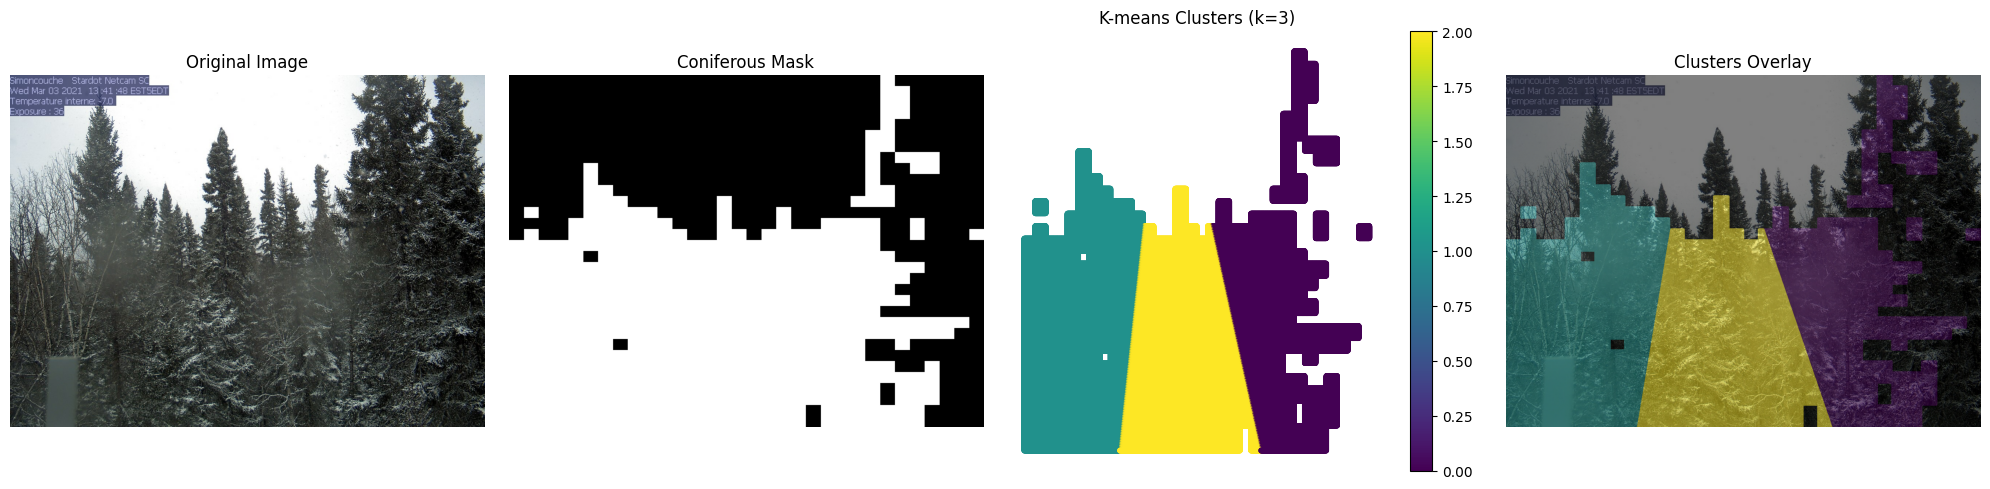


Cluster Statistics:
Cluster 1:
  Number of points: 203415
  Center: (590.4, 966.9)
  Spread: [225.91365581 113.73017678]
  Color (RGB): (68, 1, 84)

Cluster 2:
  Number of points: 236668
  Center: (651.6, 210.9)
  Spread: [175.5570387  117.04977182]
  Color (RGB): (32, 144, 140)

Cluster 3:
  Number of points: 208877
  Center: (717.7, 600.1)
  Spread: [154.03929218 118.26986975]
  Color (RGB): (253, 231, 36)



In [4]:
import torch
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from architecture import SimpleCNN

def create_cluster_overlay(image, points, labels, alpha=0.5):
    """Create an overlay of clusters on the original image"""
    overlay = image.copy()

    # Create color map for clusters
    n_clusters = len(np.unique(labels))
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
    colors = (colors[:, :3] * 255).astype(np.uint8)

    # Draw clusters with different colors
    for i in range(n_clusters):
        cluster_points = points[labels == i]
        for point in cluster_points:
            cv2.circle(overlay, (point[1], point[0]), 2, colors[i].tolist(), -1)

    # Create a mask for the points
    mask = np.zeros_like(image, dtype=np.float32)
    for i in range(n_clusters):
        cluster_points = points[labels == i]
        for point in cluster_points:
            cv2.circle(mask, (point[1], point[0]), 2, colors[i].tolist(), -1)

    # Blend the original image with the overlay
    blended = cv2.addWeighted(image, 1-alpha, mask.astype(np.uint8), alpha, 0)
    return blended, colors

def visualize_kmeans_clusters(image_path, model_path, mask_name="coniferous", n_clusters=3):
    # Load and prepare the model
    model = SimpleCNN(n_classes=3)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Read and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    H, W, _ = image.shape

    # Prepare image for model
    img_for_model = cv2.resize(image, (256, 256))
    img_for_model = img_for_model / 255.0
    img_tensor = torch.tensor(img_for_model.transpose(2, 0, 1)).float().unsqueeze(0)

    # Get model prediction
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        mask = torch.argmax(probs, dim=1).squeeze(0).numpy()

    # Create binary mask based on class
    if mask_name == "coniferous":
        selected_mask = (mask == 1)
    elif mask_name == "deciduous":
        selected_mask = (mask == 0)
    else:
        raise ValueError(f"Invalid mask_name: {mask_name}")

    # Scale mask back to original image size
    selected_mask = cv2.resize(selected_mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)

    # Get points for clustering
    points = np.argwhere(selected_mask > 0.5)

    if len(points) < 100:  # Minimum points threshold
        raise ValueError("Not enough points found in the mask for clustering")

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300, n_init=10)
    kmeans.fit(points)
    labels = kmeans.labels_

    # Create cluster overlay
    overlay_image, cluster_colors = create_cluster_overlay(original_image, points, labels)

    # Visualization
    plt.figure(figsize=(20, 5))

    # Original image
    plt.subplot(141)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Mask
    plt.subplot(142)
    plt.imshow(selected_mask, cmap='gray')
    plt.title(f"{mask_name.capitalize()} Mask")
    plt.axis('off')

    # Clusters
    plt.subplot(143)
    scatter = plt.scatter(points[:, 1], points[:, 0], c=labels, cmap='viridis', s=10)
    plt.title(f"K-means Clusters (k={n_clusters})")
    plt.gca().invert_yaxis()
    plt.colorbar(scatter)
    plt.axis('off')

    # Overlay
    plt.subplot(144)
    plt.imshow(overlay_image)
    plt.title("Clusters Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Show cluster statistics
    print("\nCluster Statistics:")
    for i in range(n_clusters):
        cluster_points = points[labels == i]
        print(f"Cluster {i+1}:")
        print(f"  Number of points: {len(cluster_points)}")
        print(f"  Center: ({np.mean(cluster_points[:, 0]):.1f}, {np.mean(cluster_points[:, 1]):.1f})")
        print(f"  Spread: {np.std(cluster_points, axis=0)}")
        color = cluster_colors[i]
        print(f"  Color (RGB): ({color[0]}, {color[1]}, {color[2]})")
        print()

    return kmeans, points, labels, overlay_image

# Example usage:
kmeans, points, labels, overlay = visualize_kmeans_clusters(
    image_path="/content/sim_2021_04_01_130201.JPG",
    model_path="/content/model_latest.pth",
    mask_name="coniferous",  # or "deciduous"
    n_clusters=3
)